In [40]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in

%matplotlib inline
%reload_ext autoreload
%autoreload 2

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import torchvision.models as models
import matplotlib.pyplot as plt
import time
import math
import tqdm as tqdm
import os

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
print(os.listdir("flower_data"))

# Any results you write to the current directory are saved as output.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

['.ipynb_checkpoints', 'cat_to_name.json', 'test', 'train', 'valid']


device(type='cpu')

# Data Folders

In [41]:
os.listdir('flower_data')

['.ipynb_checkpoints', 'cat_to_name.json', 'test', 'train', 'valid']

In [42]:
data_dir = 'flower_data'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'
name_json = data_dir + '/cat_to_name.json'

# Load the data

In [43]:
def pil_loader(path):
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')

In [44]:
class TestDataset(torch.utils.data.Dataset):
    def __init__(self, path, transform=None):
        self.path = path
        self.files = []
        for (dirpath, _, filenames) in os.walk(self.path):
            for f in filenames:
                if f.endswith('.jpg'):
                    p = {}
                    p['img_path'] = dirpath + '/' + f
                    self.files.append(p)
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_path = self.files[idx]['img_path']
        img_name = img_path.split('/')[-1]
        image = pil_loader(img_path)
        if self.transform:
            image = self.transform(image)
        return image, 0, img_name

# Label mapping

In [45]:
import json

with open(name_json, 'r') as f:
    cat_to_name = json.load(f)

In [46]:
cat_to_name

{'21': 'fire lily',
 '3': 'canterbury bells',
 '45': 'bolero deep blue',
 '1': 'pink primrose',
 '34': 'mexican aster',
 '27': 'prince of wales feathers',
 '7': 'moon orchid',
 '16': 'globe-flower',
 '25': 'grape hyacinth',
 '26': 'corn poppy',
 '79': 'toad lily',
 '39': 'siam tulip',
 '24': 'red ginger',
 '67': 'spring crocus',
 '35': 'alpine sea holly',
 '32': 'garden phlox',
 '10': 'globe thistle',
 '6': 'tiger lily',
 '93': 'ball moss',
 '33': 'love in the mist',
 '9': 'monkshood',
 '102': 'blackberry lily',
 '14': 'spear thistle',
 '19': 'balloon flower',
 '100': 'blanket flower',
 '13': 'king protea',
 '49': 'oxeye daisy',
 '15': 'yellow iris',
 '61': 'cautleya spicata',
 '31': 'carnation',
 '64': 'silverbush',
 '68': 'bearded iris',
 '63': 'black-eyed susan',
 '69': 'windflower',
 '62': 'japanese anemone',
 '20': 'giant white arum lily',
 '38': 'great masterwort',
 '4': 'sweet pea',
 '86': 'tree mallow',
 '101': 'trumpet creeper',
 '42': 'daffodil',
 '22': 'pincushion flower',
 

In [47]:
def get_cat_name(index):
    return cat_to_name[idx_to_class[index]]

In [48]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

In [49]:
normalize = transforms.Normalize(mean=mean, std=std)
data_transforms = transforms.Compose([
                    transforms.Pad(4, padding_mode='reflect'),
                    transforms.RandomRotation(10),
                    transforms.RandomResizedCrop(224),
                    transforms.RandomHorizontalFlip(),
                    transforms.ToTensor(),
                    normalize
                ])
test_transforms = transforms.Compose([
                    #transforms.Pad(4, padding_mode='reflect'),
                    transforms.RandomResizedCrop(224),
                    transforms.ToTensor(),
                    normalize
                ])

In [50]:
train_datasets = datasets.ImageFolder(train_dir, data_transforms)
val_datasets = datasets.ImageFolder(valid_dir, test_transforms)
test_datasets = TestDataset(test_dir, test_transforms)

In [51]:
bs = 64

In [52]:
trainloader = torch.utils.data.DataLoader(train_datasets, batch_size=bs, shuffle=True)
validloader = torch.utils.data.DataLoader(val_datasets, batch_size=bs, shuffle=True)
testloader = torch.utils.data.DataLoader(test_datasets, batch_size=1, shuffle=False)

In [53]:
idx_to_class = {val:key for key, val in val_datasets.class_to_idx.items()}
idx_to_class

{0: '1',
 1: '10',
 2: '100',
 3: '101',
 4: '102',
 5: '11',
 6: '12',
 7: '13',
 8: '14',
 9: '15',
 10: '16',
 11: '17',
 12: '18',
 13: '19',
 14: '2',
 15: '20',
 16: '21',
 17: '22',
 18: '23',
 19: '24',
 20: '25',
 21: '26',
 22: '27',
 23: '28',
 24: '29',
 25: '3',
 26: '30',
 27: '31',
 28: '32',
 29: '33',
 30: '34',
 31: '35',
 32: '36',
 33: '37',
 34: '38',
 35: '39',
 36: '4',
 37: '40',
 38: '41',
 39: '42',
 40: '43',
 41: '44',
 42: '45',
 43: '46',
 44: '47',
 45: '48',
 46: '49',
 47: '5',
 48: '50',
 49: '51',
 50: '52',
 51: '53',
 52: '54',
 53: '55',
 54: '56',
 55: '57',
 56: '58',
 57: '59',
 58: '6',
 59: '60',
 60: '61',
 61: '62',
 62: '63',
 63: '64',
 64: '65',
 65: '66',
 66: '67',
 67: '68',
 68: '69',
 69: '7',
 70: '70',
 71: '71',
 72: '72',
 73: '73',
 74: '74',
 75: '75',
 76: '76',
 77: '77',
 78: '78',
 79: '79',
 80: '8',
 81: '80',
 82: '81',
 83: '82',
 84: '83',
 85: '84',
 86: '85',
 87: '86',
 88: '87',
 89: '88',
 90: '89',
 91: '9',
 92:

# Plot images

In [54]:
def plot_img(preds=None, is_pred=False):        
    fig = plt.figure(figsize=(8,8))
    columns = 4
    rows = 5

    for i in range(1, columns*rows +1):
        fig.add_subplot(rows, columns, i)
        
        if is_pred:
            img_xy = np.random.randint(len(test_datasets));
            img = test_datasets[img_xy][0].numpy()           
        else:
            img_xy = np.random.randint(len(train_datasets));
            img = train_datasets[img_xy][0].numpy()
            
        img = img.transpose((1, 2, 0))
        img = std * img + mean
        
        if is_pred:
            plt.title(get_cat_name(preds[img_xy]) + "/" + get_cat_name(test_datasets[img_xy][1]))
        else:
            plt.title(str(get_cat_name(train_datasets[img_xy][1])))
        plt.axis('off')
        img = np.clip(img, 0, 1)
        plt.imshow(img, interpolation='nearest')
    plt.show()

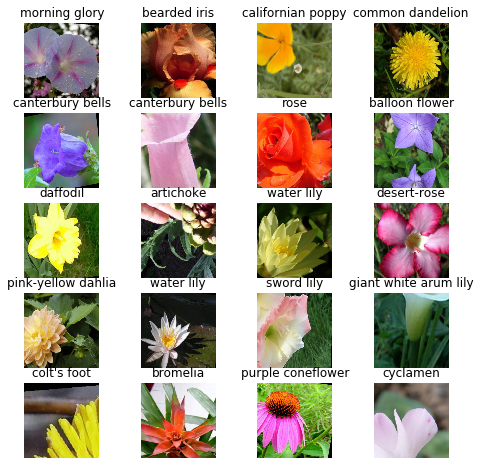

In [55]:
plot_img()

# Helper Function

In [56]:
def accuracy(output, target, is_test=False):
    global total
    global correct
    batch_size = target.size(0)
    total += batch_size    
    _, pred = output.max(dim=1)
    if is_test:
        preds.extend(pred)
    correct += torch.sum(pred == target.data)
    return  (correct.float()/total) * 100

In [57]:
def reset():
    global total, correct
    global train_loss, test_loss, best_acc
    global trn_losses, trn_accs, val_losses, val_accs
    total, correct = 0, 0
    train_loss, test_loss, best_acc = 0.0, 0.0, 0.0
    trn_losses, trn_accs, val_losses, val_accs = [], [], [], []

In [58]:
class AvgStats(object):
    def __init__(self):
        self.reset()
        
    def reset(self):
        self.losses =[]
        self.precs =[]
        self.its = []
        
    def append(self, loss, prec, it):
        self.losses.append(loss)
        self.precs.append(prec)
        self.its.append(it)

In [59]:
def save_checkpoint(model, is_best, filename='./checkpoint.pth.tar'):
    """Save checkpoint if a new best is achieved"""
    if is_best:
        torch.save(model.state_dict(), filename)  # save checkpoint
    else:
        print ("=> Validation Accuracy did not improve")

In [60]:
def load_checkpoint(model, filename = './checkpoint.pth.tar'):
    sd = torch.load(filename, map_location=lambda storage, loc: storage)
    names = set(model.state_dict().keys())
    for n in list(sd.keys()): 
        if n not in names and n+'_raw' in names:
            if n+'_raw' not in sd: sd[n+'_raw'] = sd[n]
            del sd[n]
    model.load_state_dict(sd)

# Cyclic Learning Rate

In [61]:
class CLR(object):
    """
    The method is described in paper : https://arxiv.org/abs/1506.01186 to find out optimum 
    learning rate. The learning rate is increased from lower value to higher per iteration 
    for some iterations till loss starts exploding.The learning rate one power lower than 
    the one where loss is minimum is chosen as optimum learning rate for training.

    Args:
        optim   Optimizer used in training.

        bn      Total number of iterations used for this test run.
                The learning rate increasing factor is calculated based on this 
                iteration number.

        base_lr The lower boundary for learning rate which will be used as
                initial learning rate during test run. It is adviced to start from
                small learning rate value like 1e-4.
                Default value is 1e-5

        max_lr  The upper boundary for learning rate. This value defines amplitude
                for learning rate increase(max_lr-base_lr). max_lr value may not be 
                reached in test run as loss may explode before reaching max_lr.
                It is adviced to use higher value like 10, 100.
                Default value is 100.

    """
    def __init__(self, optim, bn, base_lr=1e-7, max_lr=100):
        self.base_lr = base_lr
        self.max_lr = max_lr
        self.optim = optim
        self.bn = bn - 1
        ratio = self.max_lr/self.base_lr
        self.mult = ratio ** (1/self.bn)
        self.best_loss = 1e9
        self.iteration = 0
        self.lrs = []
        self.losses = []
        
    def calc_lr(self, loss):
        self.iteration +=1
        if math.isnan(loss) or loss > 4 * self.best_loss:
            return -1
        if loss < self.best_loss and self.iteration > 1:
            self.best_loss = loss
            
        mult = self.mult ** self.iteration
        lr = self.base_lr * mult
        
        self.lrs.append(lr)
        self.losses.append(loss)
        
        return lr
        
    def plot(self, start=10, end=-5):
        plt.xlabel("Learning Rate")
        plt.ylabel("Losses")
        plt.plot(self.lrs[start:end], self.losses[start:end])
        plt.xscale('log')
        
        
    def plot_lr(self):
        plt.xlabel("Iterations")
        plt.ylabel("Learning Rate")
        plt.plot(self.lrs)
        plt.yscale('log')

# Lookahead

In [62]:
from torch.optim import Optimizer
from collections import defaultdict


class Lookahead(Optimizer):
    r'''Implements Lookahead optimizer.

    It's been proposed in paper: Lookahead Optimizer: k steps forward, 1 step back
    (https://arxiv.org/pdf/1907.08610.pdf)

    Args:
        optimizer: The optimizer object used in inner loop for fast weight updates.
        alpha:     The learning rate for slow weight update.
                   Default: 0.5
        k:         Number of iterations of fast weights updates before updating slow
                   weights.
                   Default: 5

    Example:
        > optim = Lookahead(optimizer)
        > optim = Lookahead(optimizer, alpha=0.6, k=10)
    '''
    def __init__(self, optimizer, alpha=0.5, k=5):
        assert(0.0 <= alpha <= 1.0)
        assert(k >= 1)
        self.optimizer = optimizer
        self.alpha = alpha
        self.k = k
        self.param_groups = self.optimizer.param_groups
        self.state = defaultdict(dict)
        for group in self.param_groups:
            group['k_counter'] = 0
        self.slow_weights = [[param.clone().detach() for param in group['params']] for group in self.param_groups]
    
    def step(self, closure=None):
        loss = self.optimizer.step(closure)
        for group, slow_Weight in zip(self.param_groups, self.slow_weights):
            group['k_counter'] += 1
            if group['k_counter'] == self.k:
                for param, weight in zip(group['params'], slow_Weight):
                    weight.data.add_(self.alpha, (param.data - weight.data))
                    param.data.copy_(weight.data)
                group['k_counter'] = 0

        return loss

    def state_dict(self):
        fast_dict = self.optimizer.state_dict()
        fast_state = fast_dict['state']
        param_groups = fast_dict['param_groups']
        slow_state = {(id(k) if isinstance(k, torch.Tensor) else k): v
                        for k, v in self.state.items()}
        return {
            'fast_state': fast_state,
            'param_groups': param_groups,
            'slow_state': slow_state
        }

    def load_state_dict(self, state_dict):
        fast_dict = {
            'state': state_dict['fast_state'],
            'param_groups': state_dict['param_groups']
        }
        slow_dict = {
            'state': state_dict['slow_state'],
            'param_groups': state_dict['param_groups']
        }
        super(Lookahead, self).load_state_dict(slow_dict)
        self.optimizer.load_state_dict(fast_dict)

# Initialize Variable

In [63]:
train_loss = 0.0
test_loss = 0.0
best_acc = 0.0
trn_losses = []
trn_accs = []
val_losses = []
val_accs = []

In [64]:
total = 0
correct = 0

# LR Find

In [65]:
def update_lr(optimizer, lr):
    for g in optimizer.param_groups:
        g['lr'] = lr

In [66]:
def lr_find(clr, model, optimizer=None):
    t = tqdm.tqdm(trainloader, leave=False, total=len(trainloader))
    running_loss = 0.
    avg_beta = 0.98
    model.train()
    for i, (input, target) in enumerate(t):
        input, target = input.to(device), target.to(device)
        var_ip, var_tg = Variable(input), Variable(target)
        output = model(var_ip)
        loss = criterion(output, var_tg)
    
        running_loss = avg_beta * running_loss + (1-avg_beta) *loss.item()
        smoothed_loss = running_loss / (1 - avg_beta**(i+1))
        t.set_postfix(loss=smoothed_loss)
    
        lr = clr.calc_lr(smoothed_loss)
        if lr == -1 :
            break
        update_lr(optimizer, lr)   
    
        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# Train and Test

In [67]:
def train(epoch=0, model=None, optimizer=None):
    model.train()
    global best_acc
    global trn_accs, trn_losses
    is_improving = True
    counter = 0
    running_loss = 0.
    avg_beta = 0.98
    for i, (input, target) in enumerate(trainloader):
        bt_start = time.time()
        input, target = input.to(device), target.to(device)
        var_ip, var_tg = Variable(input), Variable(target)
                                    
        output = model(var_ip)
        loss = criterion(output, var_tg)
            
        running_loss = avg_beta * running_loss + (1-avg_beta) *loss.item()
        smoothed_loss = running_loss / (1 - avg_beta**(i+1))
        
        trn_losses.append(smoothed_loss)
            
        # measure accuracy and record loss
        prec = accuracy(output.data, target)
        trn_accs.append(prec)

        train_stats.append(smoothed_loss, prec, time.time()-bt_start)
        if prec > best_acc :
            best_acc = prec
            save_checkpoint(model, True)

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [68]:
def test(model=None):
    with torch.no_grad():
        model.eval()
        global val_accs, val_losses
        running_loss = 0.
        avg_beta = 0.98
        for i, (input, target) in enumerate(validloader):
            bt_start = time.time()
            input, target = input.to(device), target.to(device)
            var_ip, var_tg = Variable(input), Variable(target)
            output = model(var_ip)
            loss = criterion(output, var_tg)
        
            running_loss = avg_beta * running_loss + (1-avg_beta) *loss.item()
            smoothed_loss = running_loss / (1 - avg_beta**(i+1))

            # measure accuracy and record loss
            prec = accuracy(output.data, target, is_test=True)
            test_stats.append(loss.item(), prec, time.time()-bt_start)
        
            val_losses.append(smoothed_loss)
            val_accs.append(prec)

In [69]:
def fit(model=None, sched=None, optimizer=None):
    print("Epoch\tTrn_loss\tVal_loss\tTrn_acc\t\tVal_acc")
    for j in range(epoch):
        train(epoch=j, model=model, optimizer=optimizer)
        test(model)
        if sched:
            sched.step(j)
        print("{}\t{:06.8f}\t{:06.8f}\t{:06.8f}\t{:06.8f}"
              .format(j+1, trn_losses[-1], val_losses[-1], trn_accs[-1], val_accs[-1]))

# Model and Training

In [70]:
model = models.resnet50(pretrained=True)

In [71]:
model.fc = nn.Linear(in_features=model.fc.in_features, out_features=102)

In [72]:
for param in model.parameters():
    param.require_grad = False
    
for param in model.fc.parameters():
    param.require_grad = True
    
model = model.to(device)

In [73]:
save_checkpoint(model, True, 'before_start_resnet50.pth.tar')

In [74]:
criterion = nn.CrossEntropyLoss()
optim = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9, weight_decay=1e-4)
optimizer = Lookahead(optim)

In [75]:
clr = CLR(optim, len(trainloader))

In [ ]:
lr_find(clr, model, optim)


  1%|          | 1/103 [14:26<24:32:29, 866.17s/it, loss=4.64]

 26%|██▌       | 27/103 [2:07:47<8:03:02, 381.35s/it, loss=4.68]

In [ ]:
clr.plot()

In [ ]:
load_checkpoint(model, 'before_start_resnet50.pth.tar')

In [ ]:
preds = []
epoch = 30
train_stats = AvgStats()
test_stats = AvgStats()

In [ ]:
reset()

In [ ]:
criterion = nn.CrossEntropyLoss()
optim = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9, weight_decay=1e-4)
optimizer = Lookahead(optim)

In [ ]:
fit(model=model, optimizer=optimizer)

In [ ]:
save_checkpoint(model, True, 'before_unfreeze_resnet50.pth.tar')

In [ ]:
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.plot(train_stats.precs, 'r', label='Train')
plt.legend()

In [ ]:




plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.plot(train_stats.losses, 'r', label='Train')
plt.legend()

In [ ]:
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.plot(test_stats.precs, 'b', label='Valid')
plt.legend()

In [ ]:
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.plot(test_stats.losses, 'b', label='Valid')
plt.legend()

In [ ]:
preds = []
train_stats = AvgStats()
test_stats = AvgStats()

In [ ]:
reset()

In [ ]:
for param in model.parameters():
    param.require_grad = True

In [ ]:
optim = torch.optim.SGD(model.parameters(), lr=1e-6, momentum=0.9, weight_decay=1e-4)

In [ ]:
clr = CLR(optim, len(trainloader), base_lr=1e-9, max_lr=10)

In [ ]:
lr_find(clr, model, optim)

In [ ]:
clr.plot(start=0)

In [ ]:
load_checkpoint(model, 'before_unfreeze_resnet50.pth.tar')

In [ ]:
preds = []
train_stats = AvgStats()
test_stats = AvgStats()

In [ ]:
reset()

In [ ]:
optim = torch.optim.SGD(model.parameters(), lr=1e-9, momentum=0.9, weight_decay=1e-4)

In [ ]:
epoch = 10

In [ ]:
fit(model=model, optimizer=optimizer)

In [ ]:
save_checkpoint(model, True, 'after_unfreeze_resnet50.pth.tar')

In [ ]:
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.plot(train_stats.losses, 'r', label='Train')
plt.legend()

In [ ]:
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.plot(test_stats.losses, 'b', label='Valid')
plt.legend()

In [ ]:

def predict(img, model):
    model.eval()
    with torch.no_grad():
        input = Variable(img)
        input = input.to(device)
        output = model(input)
        _, pred = output.max(dim=1)
        return pred[0].item()

In [ ]:
from PIL import Image

In [ ]:
result = dict()
for i, (input, _, path) in enumerate(testloader):
    predicted = predict(input, model)
    result[path[0]] = idx_to_class[predicted]

In [ ]:
import csv

In [ ]:
!rm -rf dict.csv

In [ ]:
csv_file = open('dict.csv', 'w')
writer = csv.writer(csv_file)
writer.writerow(['file_name','id'])
for key, value in result.items():
    writer.writerow([key, value])
csv_file.close()